# Local emulation for verbatim circuits on Amazon Braket

This notebook introduces Amazon Braket's local emulator feature, a tool that enables quantum developers to emulate verbatim circuits locally based on device calibration data. By using the local emulator, you can:
- Validate your verbatim circuits against specific device constraints, using either the real-time or historical calibration data
- Debug issues before submitting tasks to the target quantum hardware
- Understand the effect of noises by comparing noiseless and noisy emulations to actual hardware results

This notebook will walk you through the steps to utilize the local emulator for these use cases, showing how it can help accelerating your quantum algorithm developments.


In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

## Emulating a verbatim circuit before submitting to the target quantum hardware

One of the benefits of using local emulator is that it allows one to more efficiently test their program before running on the target quantum device. Here, we will be using Rigetti's [Ankaa-3](https://aws.amazon.com/braket/quantum-computers/rigetti/) device as an example

In [3]:
from braket.aws.aws_device import AwsDevice

ankaa3 = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")
ankaa3_emulator = ankaa3.emulator()

Here, the local emulator is instantiated from the target device, which automatically fetches the up-to-date calibration data of the device for validation and noisy simulation. Let us examine the native gates supported by the device.

In [4]:
native_gates = ankaa3.properties.paradigm.nativeGateSet
print(f"Native gates for {ankaa3.name}: {native_gates}")

Native gates for Ankaa-3: ['rx', 'rz', 'iswap']


Now we create and visualize a 4-qubit circuit made out of these native gates

In [ ]:
from braket.circuits import Circuit

from numpy import pi

verbatim_circuit = Circuit().add_verbatim_box(
    Circuit()
    .rx(0, pi / 2)
    .rz(1, pi)
    .iswap(0, 1)
    .rx(2, -pi / 2)
    .rz(3, pi / 2)
    .iswap(2, 3)
    .iswap(1, 2)
    .rx(0, -pi / 2)
    .rz(3, -pi)
)
print(verbatim_circuit)

T  : │        0        │      1      │    2    │      3      │       4       │
                        ┌──────────┐  ┌───────┐ ┌───────────┐                 
q0 : ───StartVerbatim───┤ Rx(1.57) ├──┤ ISWAP ├─┤ Rx(-1.57) ├───EndVerbatim───
              ║         └──────────┘  └───┬───┘ └───────────┘        ║        
              ║         ┌──────────┐  ┌───┴───┐   ┌───────┐          ║        
q1 : ─────────║─────────┤ Rz(3.14) ├──┤ ISWAP ├───┤ ISWAP ├──────────║────────
              ║         └──────────┘  └───────┘   └───┬───┘          ║        
              ║         ┌───────────┐ ┌───────┐   ┌───┴───┐          ║        
q2 : ─────────║─────────┤ Rx(-1.57) ├─┤ ISWAP ├───┤ ISWAP ├──────────║────────
              ║         └───────────┘ └───┬───┘   └───────┘          ║        
              ║         ┌──────────┐  ┌───┴───┐ ┌───────────┐        ║        
q3 : ─────────╨─────────┤ Rz(1.57) ├──┤ ISWAP ├─┤ Rz(-3.14) ├────────╨────────
                        └──────────┘  └───────┘ └───

The local emulator can be used in a similar way as other deivces. Let us run the circuit and retrieve the results.

In [6]:
emulator_run = ankaa3_emulator.run(verbatim_circuit, shots=1000)
emulator_result = emulator_run.result()
emulator_counts = emulator_result.measurement_counts

The result can be visualized as follows.

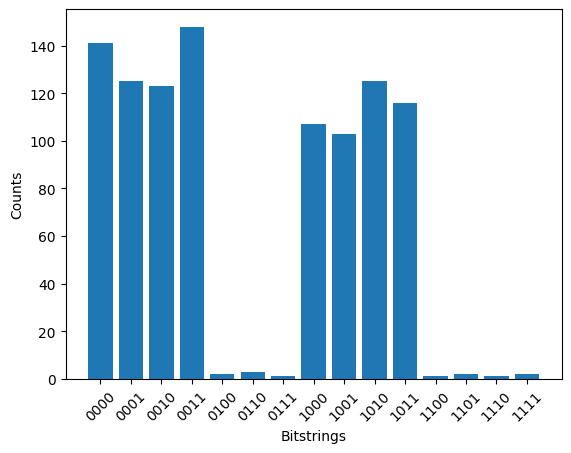

In [ ]:
from matplotlib import pyplot as plt

plt.bar(
    sorted(emulator_counts.keys()), [emulator_counts[k] for k in sorted(emulator_counts.keys())]
)
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

The noise in the device (or local emulator) manifests as the non-zero count in the bitstring, say `0100`, which would otherwise be absent in the noiseless simulation result (see below). Suppose one is satisfied with the emulation result, they can simply proceed to submit the circuit to the target QPU. 

<div class="alert alert-block alert-info">
<b>Note:</b> To run the next cell, make sure the device is currently available and note that it will result in charges on your AWS account.
</div>

In [ ]:
device_run = ankaa3.run(verbatim_circuit, shots=1000)
device_result = device_run.result()
device_counts = device_result.measurement_counts

We have demonstrated an end-to-end workflow of the local emulator with a valid verbatim circuit. As noted above, running circuit on the quantum device requires that the device is currently available and it will result in charges on your AWS account. Suppose you are developing a noise-aware quantum algorithm and need to iterate multiple times on the device, running on the actual quantum device could be inconvenient and costly. The local emulator provides another way to develop such algorithms provided that the result from the emulator is close to that from the target device. We will dive deeper into comparing the QPU and emulater results for the above example in a later section. For now, we will take a detour and explain the validation behind the emulation.

## Validating a verbatim circuit with local emulator

Before performing the noisy emulation of the verbatim circuit, the local emulator will first validate the circuit against the calibration data of the target QPU. In particular, before performing the noisy simulation, the local emulator will validate the input circuit as follows.

In [15]:
ankaa3_emulator.validate(verbatim_circuit)

Not surprisingly, the `verbatim_circuit` passes the validations against Ankaa-3's device properties, which check

1. If the qubits used in the circuit exist on the QPU
2. If the gates used in the circuit are native gates of the QPU
3. If the two-qubit gates are applied to qubits that are not connected in the device's topology

If the verbatim circuit failed any of the above validations, the local emulation will halt and output the corresponding error message. Below we will show some invalid circuits for each of the above cases.


### a. Qubit doesn't exist on the device
Ankaa-3 has 84 qubits numbered 0-83, so applying a gate on qubit 84 will throw an error

In [7]:
invalid_circuit = Circuit().add_verbatim_box(Circuit().rx(84, pi / 2))

try:
    result = ankaa3_emulator.run(invalid_circuit, shots=1000)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")

Failure with error message: Qubit Qubit(84) does not exist in the device topology. (DeviceEmulator)


If one is only interested in validating the circuit and not the noisy simulation result, they could simply validate the circuit as follows.


In [9]:
try:
    ankaa3_emulator.validate(invalid_circuit)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")

Failure with error message: Qubit Qubit(84) does not exist in the device topology. (DeviceEmulator)


#### b. Using non-native gates
As we have seen above, the native gate set for Ankaa-3 is rx, rz, and iswap. Thus, if we apply a Hadamard gate we will get an error

In [14]:
invalid_circuit = Circuit().add_verbatim_box(Circuit().h(0))

try:
    result = ankaa3_emulator.validate(invalid_circuit)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")

Failure with error message: Gate H is not a native gate for this device. (DeviceEmulator)


#### c. Applying two-qubit gates on unconnected qubits
On Ankaa-3, qubits 0 and 2 are not connected, so we cannot apply a two-qubit gate on them

In [13]:
invalid_circuit = Circuit().add_verbatim_box(Circuit().iswap(0, 2))

try:
    result = ankaa3_emulator.validate(invalid_circuit)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")

Failure with error message: 0 is not connected to qubit 2 in this device. (DeviceEmulator)


### d. Inspecting the noisy verbatim circuit

Once the verbatim circuit passes the validation, the local emulator will apply depolarizing noise to each of the gates in the circuit to mimic the noise in the target QPU. The noise model is constructed based on the device properties, and more details can be found in [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Rigetti.ipynb). The noisy circuit will be then simulated using the [local density matrix simulator](https://docs.aws.amazon.com/braket/latest/developerguide/braket-submit-tasks-simulators.html#braket-simulator-dm) (see [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Simulating_Noise_On_Amazon_Braket.ipynb) for more details on noisy simulator). We can inspect the noisy circuit as following.


In [16]:
noisy_circ = ankaa3_emulator.transform(verbatim_circuit)
print(noisy_circ)

T  : │        0        │               1               │            2             │               3               │       4       │
                        ┌──────────┐  ┌───────────────┐ ┌───────┐ ┌─────────────┐  ┌───────────┐ ┌───────────────┐                 
q0 : ───StartVerbatim───┤ Rx(1.57) ├──┤ DEPO(0.00061) ├─┤ ISWAP ├─┤ DEPO(0.021) ├──┤ Rx(-1.57) ├─┤ DEPO(0.00061) ├───EndVerbatim───
              ║         └──────────┘  └───────────────┘ └───┬───┘ └──────┬──────┘  └───────────┘ └───────────────┘        ║        
              ║         ┌──────────┐  ┌───────────────┐ ┌───┴───┐ ┌──────┴──────┐    ┌───────┐    ┌─────────────┐         ║        
q1 : ─────────║─────────┤ Rz(3.14) ├──┤ DEPO(0.00099) ├─┤ ISWAP ├─┤ DEPO(0.021) ├────┤ ISWAP ├────┤ DEPO(0.015) ├─────────║────────
              ║         └──────────┘  └───────────────┘ └───────┘ └─────────────┘    └───┬───┘    └──────┬──────┘         ║        
              ║         ┌───────────┐ ┌───────────────┐ ┌───────┐ ┌─────────

## Comparing emulator results to the target QPU

Next, we want to see how well does the emulator capture the device results as compared to the noiseless simulator. Let's start by getting the noiseless simulation result.

In [ ]:
from braket.devices import LocalSimulator

local_sim = LocalSimulator()

sim_run = local_sim.run(verbatim_circuit, shots=1000).result()
sim_counts = sim_run.measurement_counts

Since we have obtained the (noisy) emulation and QPU results above, we now plot all the results to visualize them.

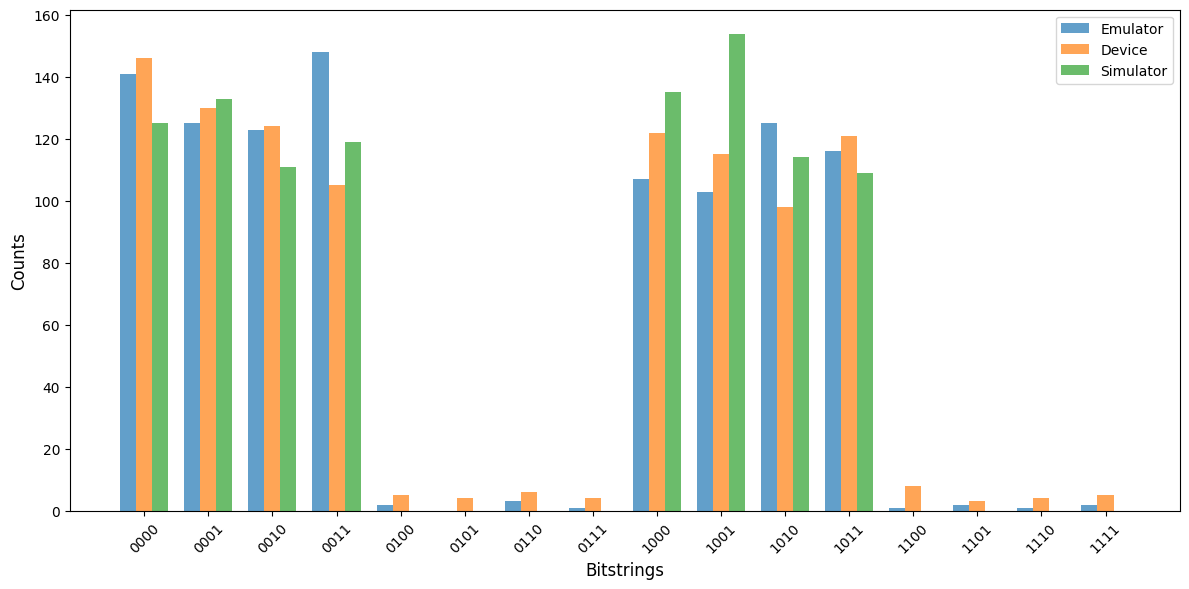

In [ ]:
import numpy as np

all_bitstrings = sorted(
    set(list(emulator_counts.keys()) + list(device_counts.keys()) + list(sim_counts.keys()))
)

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(all_bitstrings))

emulator_bars = ax.bar(
    x - bar_width,
    [emulator_counts.get(b, 0) for b in all_bitstrings],
    bar_width,
    label="Emulator",
    alpha=0.7,
)

device_bars = ax.bar(
    x, [device_counts.get(b, 0) for b in all_bitstrings], bar_width, label="Device", alpha=0.7
)

sim_bars = ax.bar(
    x + bar_width,
    [sim_counts.get(b, 0) for b in all_bitstrings],
    bar_width,
    label="Simulator",
    alpha=0.7,
)

ax.set_xlabel("Bitstrings", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(all_bitstrings, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

To quantify the discrepancy between the three results, we compute the fidelity between their respective bit-string probabilities, defined for two arrays $p$ and $q$ as
$$ \text{fidelity} = (\sum_i \sqrt{p_i q_i})^2$$

First, we get the probabilities for each result

In [ ]:
import pandas as pd

emulator_probs_dict = emulator_result.measurement_probabilities
sim_probs_dict = sim_run.measurement_probabilities
device_probs_dict = device_result.measurement_probabilities

emulator_probs_df = pd.DataFrame.from_dict(emulator_probs_dict, orient="index").rename(
    columns={0: "emulator"}
)
sim_probs_df = pd.DataFrame.from_dict(sim_probs_dict, orient="index").rename(columns={0: "sim"})
device_probs_df = pd.DataFrame.from_dict(device_probs_dict, orient="index").rename(
    columns={0: "device"}
)
df = device_probs_df.join(sim_probs_df).join(emulator_probs_df)
df

,device,sim,emulator
0110,0.006,NaN,0.003
1010,0.098,0.114,0.125
1011,0.121,0.109,0.116
0000,0.146,0.125,0.141
0001,0.130,0.133,0.125
0010,0.124,0.111,0.123
1000,0.122,0.135,0.107
0011,0.105,0.119,0.148
1001,0.115,0.154,0.103
1101,0.003,NaN,0.002


Then we define and compute the fidelity

In [ ]:
import numpy as np


def fidelity(p, q):
    return np.sum(np.sqrt(p * q)) ** 2


print(
    f"\nFidelity between Ankaa-3 and noise-free simulator is {fidelity(df['device'], df['sim']):.3f}"
)
print(f"\nFidelity between Ankaa-3 and emulator is {fidelity(df['device'], df['emulator']):.3f}")


Fidelity between Ankaa-3 and noise-free simulator is 0.956

Fidelity between Ankaa-3 and emulator is 0.982


We see that, indeed, the local emulator produces results closer to the QPU result than that of the noiseless simulator.

## Emulating a verbatim circuit with custom device properties

In the above example, we have seen how to instantiate a device emulator using up-to-date device properties from an AWS device. Another important application for the local emulator is to perform local validation and emulation using historical calibration data from the AWS devices or custom device properties. For that, let us first load the calibration data from the IQM Garnet device dated July 6th 2025.

In [10]:
import json

with open("iqm_device_properties_20250706.json", "r") as json_file:
    garnet_data_json = json.load(json_file)

The json file for the calibration data of AWS devices can be downloaded from the AWS console or using Braket SDK, as shown in the below commented code

In [ ]:
# import datetime

# garnet_properties_json = garnet.properties.json()

# dt = datetime.now()
# dt_string = dt.strftime("%Y%m%d")

# with open(f"garnet_device_properties_{dt_string}.json", "w") as f:
#     json.dump(garnet_properties_json, f)

We can confirm the date of the calibration data as follows

In [ ]:
garnet_data_dict = json.loads(garnet_data_json)
print(garnet_data_dict["service"]["updatedAt"])

2025-07-06T17:52:53.997626+00:00


A local device emulator can be instantiated using the device properties json as the following

In [13]:
from braket.emulation.local_emulator import LocalEmulator

garnet_emulator = LocalEmulator.from_json(garnet_data_json)

The local emulator can be used in exactly the same way as illustrated above. Let us build several verbatim circuits made of a series of cz gates, the native two-qubit gate supported on the Garnet device, and check their validity.

In [ ]:
def get_verbatim_circuit_garnet(q1, q2, num_cz):
    circ = Circuit()
    for _ in range(num_cz):
        circ.cz(q1, q2)

    circ = Circuit().add_verbatim_box(circ)
    try:
        garnet_emulator.validate(circ)
        print("Success!")
    except Exception as e:
        print(f"Failure with error message: {str(e)}")

    return circ


verbatim_circuit_garnet_1 = get_verbatim_circuit_garnet(0, 1, 10)
verbatim_circuit_garnet_2 = get_verbatim_circuit_garnet(2, 3, 10)
verbatim_circuit_garnet_3 = get_verbatim_circuit_garnet(1, 2, 10)

Failure with error message: 0 is not connected to qubit 1 in this device. (DeviceEmulator)
Failure with error message: 2 is not connected to qubit 3 in this device. (DeviceEmulator)
Success!


We see that the first two circuits do not comply with the device constraints and the local emulator was able to correctly spot the failures. For the third circuit, if there is no noise, the circuit is equivalent to an identity circuit and the only bitstring output would be `00`. On the other hand, the presence of noise indicating that the fidelity of `00` would not be unity and we are interested in how its probability depends on the noise of the cz gate of the device. For that, let us first visualize the noisy version of `verbatim_circuit_garnet_3`.

In [17]:
noisy_verbatim_circuit_garnet_3 = garnet_emulator.transform(verbatim_circuit_garnet_3)
print(noisy_verbatim_circuit_garnet_3)

T  : │        0        │          1          │          2          │          3          │          4          │          5          │          6          │          7          │          8          │          9          │         10          │      11       │
                              ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐       ┌─────────────┐                 
q1 : ───StartVerbatim─────●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───●───┤ DEPO(0.018) ├───EndVerbatim───
              ║           │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬──────┘   │   └──────┬───

Note that the parameter in the depolarizing channel is extracted from the calibration data of Garnet dated July 6th 2025. For our purpose, we can modify the calibration data for the `q1-q2` pair as follows

In [38]:
garnet_data_dict = json.loads(garnet_data_json)
garnet_data_dict["standardized"]["twoQubitProperties"]["1-2"]["twoQubitGateFidelity"][0][
    "fidelity"
] = 1.0
garnet_data_json_modified = json.dumps(garnet_data_dict)

Here we have set the cz gate for the `q1-q2` pair to be a noiseless gate with fidelity 1.0. We can instantiate the local emulator and inspect the noisy circuit again.

In [39]:
garnet_emulator = LocalEmulator.from_json(garnet_data_json_modified)
noisy_verbatim_circuit_garnet_3 = garnet_emulator.transform(verbatim_circuit_garnet_3)
print(noisy_verbatim_circuit_garnet_3)

T  : │        0        │        1        │        2        │        3        │        4        │        5        │        6        │        7        │        8        │        9        │       10        │      11       │
                              ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐       ┌─────────┐                 
q1 : ───StartVerbatim─────●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───●───┤ DEPO(0) ├───EndVerbatim───
              ║           │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘   │   └────┬────┘        ║        
              ║         ┌─┴─┐ ┌────┴────┐ ┌─┴─┐ ┌────┴────┐ ┌─┴─┐ ┌────┴────┐ ┌─┴─┐ ┌────┴────┐ ┌─┴─┐ ┌────┴────┐ ┌─

In the above diagram `DEPO(0)` indidates a depolarizing channel with noise rate equal to 0, for which we expect that the circuit would return `00` with unity probability. Let us vary the noise rate of the cz gate for the `q1-q2` pair and plot the probability of `00` from the local emulator.

In [49]:
fidelity_list = [
    i / 100
    for i in range(
        90,
        101,
    )
]
shots = 1000
counts_list = []
for fidelity in fidelity_list:
    garnet_data_dict = json.loads(garnet_data_json_modified)
    garnet_data_dict["standardized"]["twoQubitProperties"]["1-2"]["twoQubitGateFidelity"][0][
        "fidelity"
    ] = fidelity
    garnet_data_json_modified = json.dumps(garnet_data_dict)

    garnet_emulator = LocalEmulator.from_json(garnet_data_json_modified)
    counts = garnet_emulator.run(verbatim_circuit_garnet_3, shots=shots).result().measurement_counts
    counts_list.append(counts.get("00", 0) / shots)

Text(0.5, 1.0, 'Probability of 00 vs CZ gate fidelity')

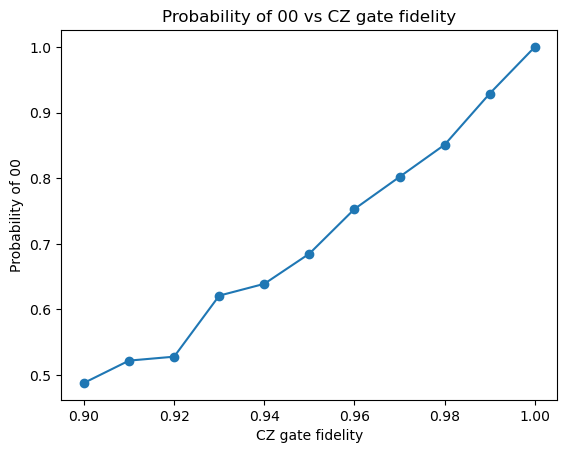

In [52]:
import matplotlib.pyplot as plt

plt.plot(fidelity_list, counts_list, marker="o")
plt.xlabel("CZ gate fidelity")
plt.ylabel("Probability of 00")
plt.title("Probability of 00 vs CZ gate fidelity")

Indeed, we see that the probability of obtaining `00` is increasing as we increase the cz gate fidelity. This example shows how one could use custom device properties to perform local emulation, which could useful for developing noise-aware algorithms, or characterizing the target device.

## Summary
In this notebook, we have shown how to utilize the local emulator to perform noisy simulation for Braket devices with real-time noise parameters. We have also shown how we can use historically saved noise parameters to perform noisy simulations for a device state on a particular day.

In [8]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD",
)

Quantum Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3': {'shots': 1000, 'tasks': {'CREATED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 1.200 USD
